# Replication of results from "Prediction of ceftriaxone MIC in <i>Neisseria gonorrhoeae</i> using DNA microarray technology and regression analysis" in Python

&emsp;In the original paper "Prediction of ceftriaxone MIC in <i>Neisseria gonorrhoeae</i> using DNA microarray technology and regression analysis" (https://doi.org/10.1093/jac/dkab308) minimal inhibitory concentration (MIC) prediction is carried out in R. I set myself a goal to replicate the results using Python. The main objective of the work is to train a linear regression model that would be capable of prediciting MIC of ceftriaxone based on mutations present in N. gonorrhoeae genome.

## Data analysis and preprocessing

In [136]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as mnso

&emsp;Loading the data with pandas:

In [137]:
df = pd.read_excel("./Table_S1.xlsx", header=3, index_col=0)
df.head()

,penA allele,Name,Date,Collection,Country,"Ceftriaxone MIC, mg/L",Ala311Val,Ile312Met,Val316Thr,insAsp(345-346),...,Gly120Lys,Gly120Arg,Ala121Gly,Ala121Ser,Ala121Asp,Ala121Asn,Ala121Val,Ala121Arg,Leu421Pro,-35delA
#,,,,,,,,,,,,,,,,,,,,,
1,100.001,SRR1661159,2001,demczuk2015,Canada,0.00025,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,100.001,SRR1661178,2005,demczuk2015,Canada,0.00050,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,100.001,SRR1661264,2010,demczuk2015,Canada,0.00050,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,22.001,SRR1661260,2010,demczuk2015,Canada,0.00050,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,15.001,ECDC_T2_ES012,2013,eurogasp2013,Estonia,0.00070,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [138]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5812 entries, 1 to 5812
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   penA allele            5812 non-null   float64
 1   Name                   5812 non-null   object 
 2   Date                   5812 non-null   object 
 3   Collection             5812 non-null   object 
 4   Country                5812 non-null   object 
 5   Ceftriaxone MIC, mg/L  5812 non-null   float64
 6   Ala311Val              5812 non-null   int64  
 7   Ile312Met              5812 non-null   int64  
 8   Val316Thr              5812 non-null   int64  
 9   insAsp(345-346)        5812 non-null   int64  
 10  Thr483Ser              5812 non-null   int64  
 11  Ala501Val              5812 non-null   int64  
 12  Ala501Thr              5812 non-null   int64  
 13  Ala501Pro              5812 non-null   int64  
 14  Asn512Tyr              5812 non-null   int64  
 15  Gly542Ser

The DataFrame contained 5812 rows and 31 columns:<br>
- penA allele - type of penA allele designated by a number (categorical variable);<br>
- Name - SRA Run Id;<br>
- Date - the year when the data was uploaded;<br>
- Collection - name of the collection from which the data comes from;<br>
- Country - origin of the isolate;<br>
- Ceftriaxone MIC, mg/L - minimal inhibitory concentration of ceftriaxone in mg/L (float);<br>
- Ala311Val...-35delA - mutations in N. gonorrhoeae genome that are responsible for resistance (boolean).<br>

In [139]:
# Delete duplicate rows
df = df.drop_duplicates()

Among 5812 rows there were 95 duplicates. These were definitely duplicates as they shared the same SRA Run Id. The remaining amount of rows is 5717.

Text(0.5, 1.0, 'Matrix of missing values')

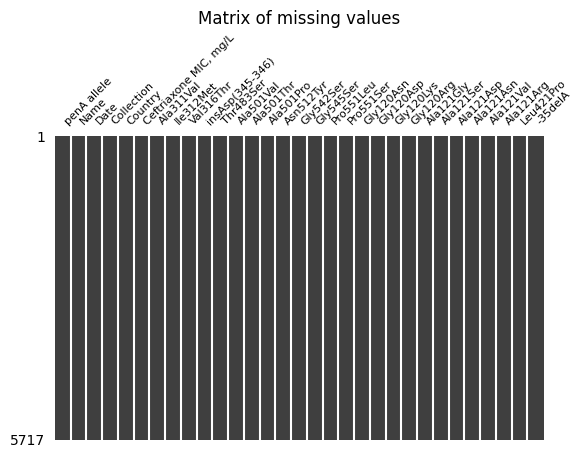

In [ ]:
cm = 1 / 2.54  # cm to inches conversion
fig, ax = plt.subplots(1, 1, figsize=(16 * cm, 10 * cm))
mnso.matrix(df, ax=ax, fontsize=8, sparkline=False)
plt.title("Matrix of missing values")

As we can see, the dataset contains no missing values.

To train a model we need features (columns: Ala311Val...-35delA) and a target variable (column: Ceftriaxone MIC, mg/L). The other columns were not used in the analysis in the paper.

In [141]:
# Dropping columns that were not used in the analysis.
df = df.drop(axis=1, columns=df.columns[range(5)])

# Renaming target variable for the ease of use.
df = df.rename({"Ceftriaxone MIC, mg/L": "cft_mic"}, axis=1)
df.head()

,cft_mic,Ala311Val,Ile312Met,Val316Thr,insAsp(345-346),Thr483Ser,Ala501Val,Ala501Thr,Ala501Pro,Asn512Tyr,...,Gly120Lys,Gly120Arg,Ala121Gly,Ala121Ser,Ala121Asp,Ala121Asn,Ala121Val,Ala121Arg,Leu421Pro,-35delA
#,,,,,,,,,,,,,,,,,,,,,
1,0.00025,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0.00050,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0.00050,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0.00050,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0.00070,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [142]:
# Changing variable type (less memory usage).
df.iloc[:, 1:] = df.iloc[:, 1:].astype("Int8")

In [143]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5717 entries, 1 to 5812
Data columns (total 26 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   cft_mic          5717 non-null   float64
 1   Ala311Val        5717 non-null   int64  
 2   Ile312Met        5717 non-null   int64  
 3   Val316Thr        5717 non-null   int64  
 4   insAsp(345-346)  5717 non-null   int64  
 5   Thr483Ser        5717 non-null   int64  
 6   Ala501Val        5717 non-null   int64  
 7   Ala501Thr        5717 non-null   int64  
 8   Ala501Pro        5717 non-null   int64  
 9   Asn512Tyr        5717 non-null   int64  
 10  Gly542Ser        5717 non-null   int64  
 11  Gly545Ser        5717 non-null   int64  
 12  Pro551Leu        5717 non-null   int64  
 13  Pro551Ser        5717 non-null   int64  
 14  Gly120Asn        5717 non-null   int64  
 15  Gly120Asp        5717 non-null   int64  
 16  Gly120Lys        5717 non-null   int64  
 17  Gly120Arg        57

In [144]:
df = df.reset_index(drop=True)  # Reset index (duplicate columns were dropped).

In [145]:
y = df.iloc[:, 0]  # Target variable.

X = df.iloc[:, 1:]  # Features.

It is a good idea to analyse target variable distribution before training a model.

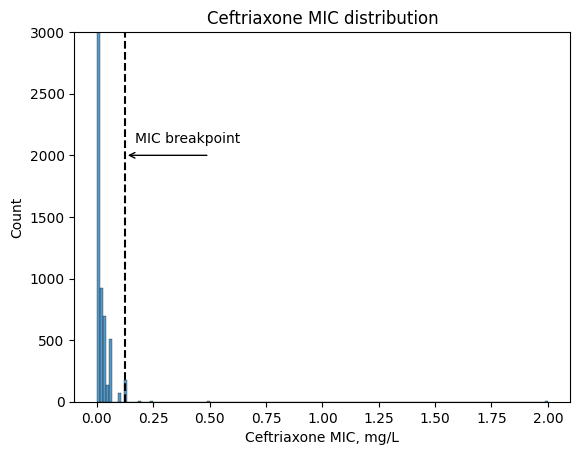

In [147]:
sns.histplot(y)
plt.title("Ceftriaxone MIC distribution")
plt.xlabel("Ceftriaxone MIC, mg/L")
plt.vlines(x=[0.125], ymin=0, ymax=4000, colors="black", linestyles="dashed")
plt.annotate(
    "",
    xytext=(0.500, 2000),
    xy=(0.125, 2000),
    arrowprops=dict(arrowstyle="->"),
    horizontalalignment="center",
    verticalalignment="bottom",
)
plt.text(s="MIC breakpoint", x=0.17, y=2100)
plt.ylim((0, 3000))
plt.show()

As we can see most of the observations lie before the MIC breakpoint (black dashed line at 0.125 mg/L). A few data points of resistant isolates are found after the breakpoint. It is certain that the distribution is not normal (right-skewed) and for that reason the target variable should be transformed (for this case log transformation would be appropriate).

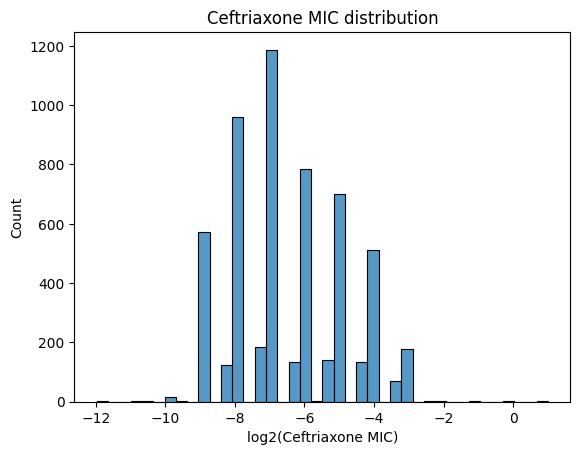

In [148]:
sns.histplot(np.log2(y))
plt.title("Ceftriaxone MIC distribution")
plt.xlabel("log2(Ceftriaxone MIC)")
plt.show()

Now the data looks more bell-shaped. Now linear regression can be used on this data.

## Training linear regression model

In [234]:
from sklearn.model_selection import train_test_split

# Splitting dataset into training (75%) and test (25%) data.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=8798
)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(4287, 25) (1430, 25) (4287,) (1430,)


In [323]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import TransformedTargetRegressor, ColumnTransformer

# Exctract feature names.
features = X.columns

# Impute missing values in case they will be encountered during prediction.
preprocessor = ColumnTransformer(
    transformers=[("imputer", SimpleImputer(strategy="most_frequent"), features)]
)

# Transform target variable with log2.
target_transformation_regression = TransformedTargetRegressor(
    regressor=LinearRegression(),
    func=lambda x: np.log2(x),
    inverse_func=lambda x: np.exp2(x),
)

# Creating a pipeline with preprocessor and regression steps.
linear_model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("linear_regression", target_transformation_regression),
    ]
)

In [325]:
# Fit data.
linear_model.fit(X_train, y_train)
print()

In [239]:
from sklearn.metrics import r2_score, mean_squared_error


def print_statistics(y_true_train, X_train, y_true_test, X_test, model):
    """
    A function to calculate R² and MSE for train and test data.
    """
    print(f"Train statistics: ")
    print("R² = {:.4f}".format(r2_score(y_true_train, model.predict(X_train))))
    print(
        "MSE = {:.4e}".format(mean_squared_error(y_true_train, model.predict(X_train)))
    )
    print()
    print(f"Test statistics: ")
    print("R² = {:.4f}".format(r2_score(y_true_test, model.predict(X_test))))
    print("MSE = {:.4e}".format(mean_squared_error(y_true_test, model.predict(X_test))))
    print()

In [241]:
# Statistics of the trained model.
print_statistics(y_train, X_train, y_test, X_test, linear_model)

Train statistics: 
R² = 0.8462
MSE = 5.8080e-04

Test statistics: 
R² = 0.7059
MSE = 3.0906e-04



From calculated statistics we can see that a linear regression with log2 transformation is not ideal but it gives moderately good resulsts. Let's see the coefficients of the model:

In [280]:
coefficients = pd.DataFrame(
    linear_model[1].regressor_.coef_, columns=["Coefficients"], index=features
)
coefficients.sort_values(by="Coefficients", key=lambda x: abs(x), ascending=False)

,Coefficients
Ala501Pro,5.211000
Gly120Arg,2.117484
Ala311Val,1.662172
Thr483Ser,1.662172
Gly545Ser,1.656373
insAsp(345-346),1.333320
Gly542Ser,1.242723
Ala501Val,1.226636
Gly120Lys,1.204336
Pro551Ser,1.021032


It is better to visualise our coefficients using horizontal barplot:

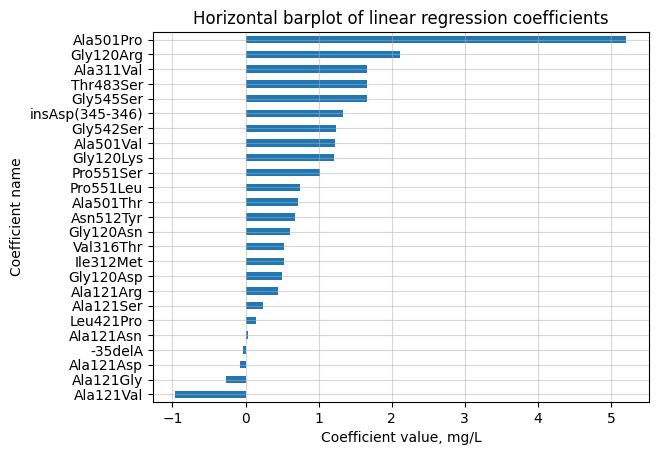

In [297]:
coefficients.sort_values(by="Coefficients").plot.barh(
    legend=False,
    xlabel="Coefficient value, mg/L",
    ylabel="Coefficient name",
    title="Horizontal barplot of linear regression coefficients",
)
plt.grid(alpha=0.5)
plt.show()

Horizontal barplot shows clearly that there are variables that strongly affect MIC of ceftriaxone like: Ala501Pro, Gly120Arg, Thr483Ser, Gly545Ser, insAsp(345-346), Gly542Ser, Ala501Val, Gly120Lys, Pro551Ser, Ala121Val. There are also variables that have almost no effect on the target variable like: Ala121Asp, -35delA, Ala121Asn, Leu421Pro, Ala121Ser, Ala121Gly. Other variables moderately affect the target variable.

We can try to remove variables that have no effect on the target variable and retrain the model.

## Retrain model with less variables

In [326]:
features_reduced = [
    i
    for i in X.columns
    if i
    not in ["Ala121Asp", "-35delA", "Ala121Asn", "Leu421Pro", "Ala121Ser", "Ala121Gly"]
]

# Impute missing values in case they will be encountered during prediction.
preprocessor_reduced = ColumnTransformer(
    transformers=[
        ("imputer", SimpleImputer(strategy="most_frequent"), features_reduced)
    ]
)

# Creating a pipeline with preprocessor and regression steps.
linear_model_reduced = Pipeline(
    steps=[
        ("preprocessor", preprocessor_reduced),
        ("linear_regression", target_transformation_regression),
    ]
)

In [327]:
linear_model_reduced.fit(X_train[features_reduced], y_train)
print()

In [314]:
print_statistics(
    y_train,
    X_train[features_reduced],
    y_test,
    X_test[features_reduced],
    linear_model_reduced,
)

Train statistics: 
R² = 0.8461
MSE = 5.8110e-04

Test statistics: 
R² = 0.7048
MSE = 3.1019e-04



Let's compare the results of the original and the new model with reduced amount of variables:<br>
1) Train statistics:<br>
> Origianl: R² = 0.8462 | New: R² = 0.8461;<br>
> Origianl: MSE = 5.8080e-04 | New: MSE = 5.8110e-04.<br>
Train statistics remained largely the same.<br>

2) Test statistics:<br>
> Origianl: R² = 0.7059 | New: R² = 0.7048;<br>
> Origianl: MSE = 3.0906e-04 | New: MSE = 3.1019e-04.<br>
Test statistics remained largely the same.<br>

We can conclude that removed variables were not important for the linear regression model.

## The model proposed in the paper

In the original paper the Akaike information criterion was used to determine unimportant variables. Features that were removed are: Val316Thr, Thr483Ser, Ala121Asn, Ala121Arg, -35delA (only -35delA and Ala121Asn were both removed from my model and from the author's model).<br>
Now I will train and test the proposed model and compare it to the model that I previously trained.

In [328]:
features_paper = [
    i
    for i in X.columns
    if i not in ["Val316Thr", "Thr483Ser", "Ala121Asn", "Ala121Arg", "-35delA"]
]

# Impute missing values in case they will be encountered during prediction.
preprocessor_paper = ColumnTransformer(
    transformers=[("imputer", SimpleImputer(strategy="most_frequent"), features_paper)]
)

# Creating a pipeline with preprocessor and regression steps.
linear_model_paper = Pipeline(
    steps=[
        ("preprocessor", preprocessor_paper),
        ("linear_regression", target_transformation_regression),
    ]
)

In [329]:
linear_model_paper.fit(X_train[features_paper], y_train)
print()

In [318]:
print_statistics(
    y_train, X_train[features_paper], y_test, X_test[features_paper], linear_model_paper
)

Train statistics: 
R² = 0.8461
MSE = 5.8098e-04

Test statistics: 
R² = 0.7060
MSE = 3.0896e-04



In [321]:
coefficients_paper = pd.DataFrame(
    linear_model_paper[1].regressor_.coef_,
    columns=["Coefficients"],
    index=features_paper,
)
coefficients_paper.sort_values(by="Coefficients", key=lambda x: abs(x), ascending=False)

,Coefficients
Ala501Pro,5.209523
Ala311Val,3.322759
Gly120Arg,2.446465
Gly545Ser,1.654285
insAsp(345-346),1.333082
Gly542Ser,1.243511
Gly120Lys,1.234166
Ala501Val,1.225806
Ile312Met,1.061330
Pro551Ser,1.017283


The coefficients obtained are almost identical to the ones calculated in the article (dew to the nature of randomness in training).

Let's compare the results of the original and the new model with reduced amount of variables:<br>
1) Train statistics:<br>
> Paper model: R² = 0.8461 | My model: R² = 0.8461;<br>
> Paper model: MSE = 5.8098e-04 | My model: MSE = 5.8110e-04.<br>
Train statistics is almost the same.<br>

2) Test statistics:<br>
> Paper model: R² = 0.7060 | My model: R² = 0.7048;<br>
> Paper model: MSE = 3.0896e-04 | My model: MSE = 3.1019e-04.<br>
Test statistics is almost the same.<br>

We can see that the models perfrom equally well with almost identical R² coefficients and MSE. This tells us that linear regression model might not be the optimal one since even with differen variables present the result stays largely the same.

## Conclusion

1) In this work a dataset from https://doi.org/10.1093/jac/dkab308 was analysed. There were found 95 duplicate rows in the dataset which reduced the amount of observations from 5812 to 5717. No missing values were found.<br>
2) The target variable in the dataset was non-normally distributed (right-skewed). Log2 transformation was used to make the distribution look more bell-shaped.<br>
3) The first trained model with no features deleted performed pretty well with moderately high R² coefficient and low MSE on training and test data (Train statistics: R² = 0.8462, MSE = 5.8080e-04 | Test statistics: R² = 0.7059, MSE = 3.0906e-04).<br>
4) The model with reduced amount of features performed as good as the first model (Train statistics: R² = 0.8461, MSE = 5.8110e-04 | Test statistics: R² = 0.7048, MSE = 3.1019e-04).<br>
5) The model proposed in the paper performed as well as my models (Train statistics: R² = 0.8461,MSE = 5.8098e-04 | Test statistics: R² = 0.7060, MSE = 3.1019e-04).<br>
6) The proposed model coefficients were almost identical to the ones calculated in the article (dew to the nature of randomness in the training process).<br>
7) It could be speculated that the linear regression model is not ideal for this type of problem since removing different coefficients results in largely the same model behaviour. On top of that not all of the genetic determinants of resistance are found leading to an acceptable R² coefficient value (<0.9).
